### Computational Guided Inquiry for Modeling Earth's Climate (Neshyba & Deloya Garcia, 2023)

# Cambio 3.0

## Cambio 3.0 equations of motion
The equations of motion for Cambio3 are as follows:

$$
F_{land->atm} =  k_{la} \ \ \ (1) 
$$

$$
F_{atm->land} = k_{al0} +  k_{al1} \times \sigma_{floor}(T_{anomaly}) \times [C_{atm}] \ \ \ (2)
$$

$$
F_{ocean->atm} = k_{oa} (1+T_{anomaly} \times DC) \times [C_{ocean}] \ \ \ (3)
$$ 

$$
F_{atm->ocean} = k_{ao} [C_{atm}] \ \ \ (4)
$$

$$
F_{human->atm} = \epsilon(t) \ \ \ (5)
$$


### New in Cambio3.0
The big difference in Cambio3.0 is the incorporation of feedbacks. We'll divide this into different levels, each building on the previous level, as follows:

- Level 0 -- no feedbacks. It's the same as Cambio2. 
- Level 1 -- This takes into account the temperature dependence of the ocean-to-atmosphere flux, $F_{ocean->atm}$, as described by Eq. 3. You don't have to re-write that algorithm here, however, since you already implemented it when you wrote the Python function *Diagnose_F_oa*; that function pulls $DC$ (the degassing coefficient for $CO_2$ in water) out of the *ClimateParams* dictionary. Since *Diagnose_F_oa* takes *T_anomaly* as an imput argument, you'll have to first make a call to *Diagnose_T_anomaly*.
- Level 2 -- This includes Level 1, but adds the effect of temperature anomaly on the atmosphere->land flux, $F_{atm->land}$, as described by Eq. 2. You don't have to re-write that algorithm either, however, because you already implemented it when you wrote the Python function *Diagnose_F_al*. That function pulls parameters controlling $\sigma_{floor}$ out of the *ClimateParams* dictionary (see the cell defining the *ClimateParams* dictionary below for details).
- Level 3 -- On top of Level 2, this level adds ice-albedo feedback. This is done by recognizing that the temperature anomaly needs to be corrected by the amount $AS \times (\alpha - \alpha_{preindust})$, where $AS$ is the albedo sensitivity parameter stored in the *ClimateParams* dictionary. You also already implemented this algorithm, in the diagnostic function *Delta_T_from_albedo*. Once you have that correction, you can adjust *T_anomaly* using Python's "+=" syntax. 

### Using the Conn350Lib for diagnostic functions
As we did in Cambio2.0, the diagnostic functions just mentioned have been made available to you via our Python library, *Conn350Lib*, for your convenience. Below we import these in the usual way, so that a "CL." prefix is needed to use them. For example, to invoke *Diagnose_F_oa*, we need to say *CL.Diagnose_F_oa*.

### Learning goals
1. I can implement feedbacks within an Euler loop of prognostic variable evolution (as described above)
1. I know how to activate various feedbacks, impacts, and constraints, including:
- the impact of temperature on carbon fluxes, and vice versa
- the impact of albedo on temperature, and vice versa
- constraint on how fast Earth's albedo can change
3. I understand how tipping points control the course of climate progress

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import sys; sys.path.append('/home'); import Conn350Lib as CL
from copy import copy as makeacopy

In [2]:
%matplotlib notebook

### Reading in an emissions scenario
In the cell below, we use CL.GetMyScenario to read in an emissions scenario, turning on flags that report the metadata, plot the emissions, and return the epsdictionary. Feel free to modify to specify a different emissions scenario.

We're also adding some cosmetics for later plotting.

Here's the scenario summary:


{'LTE': 4,
 'dataframe':             time  emissions
 0    1750.000000   0.013363
 1    1750.450450   0.013514
 2    1750.900901   0.013667
 3    1751.351351   0.013822
 4    1751.801802   0.013978
 ..           ...        ...
 995  2198.198198   4.000000
 996  2198.648649   4.000000
 997  2199.099099   4.000000
 998  2199.549550   4.000000
 999  2200.000000   4.000000
 
 [1000 rows x 2 columns],
 'delta_t_trans': 20,
 'emission units': 'GtC/year',
 'eps_0': 11.3,
 'k': 0.025,
 'nsteps': 1000,
 't_0': 2020,
 't_peak': 2040,
 't_start': 1750,
 't_stop': 2200}

<IPython.core.display.Javascript object>


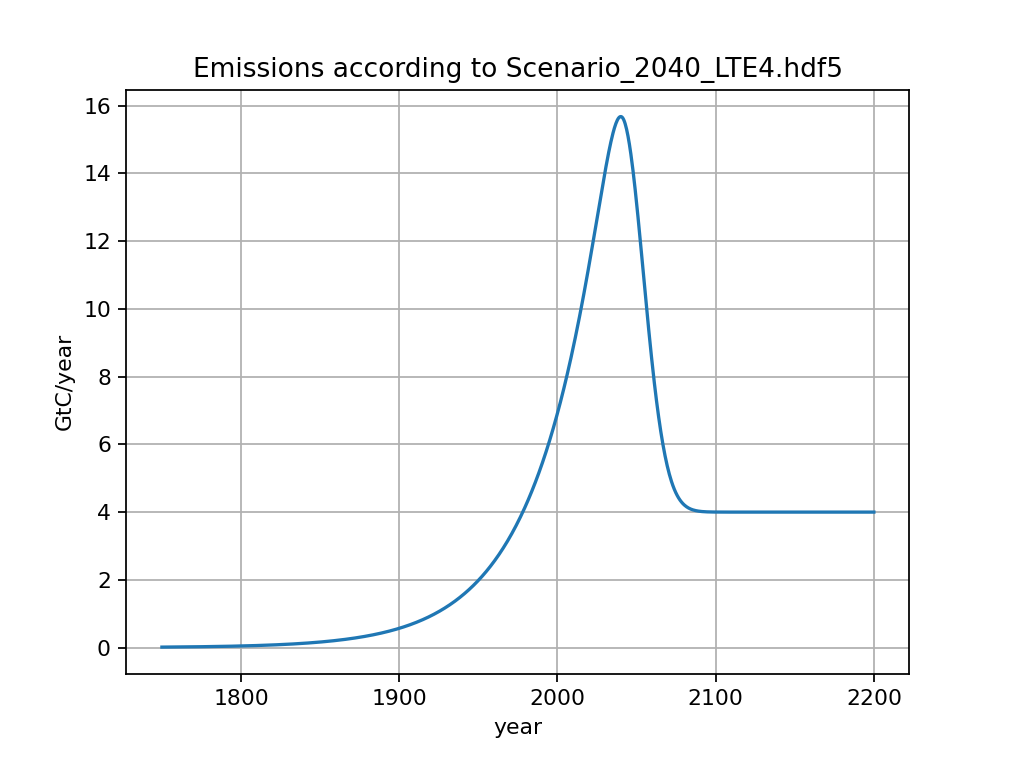

In [3]:
# Reading in the emissions scenario file
filename = 'Scenario_2040_LTE4.hdf5'
time, eps, epsdictionary = CL.GetMyScenario(\
        filename,reportflag=True,plotflag=True,epsdictionaryflag=True)

### The ClimateParams dictionary
The cell below creates a dictionary of climate parameters.

In [4]:
# Start with an empty dictionary
ClimateParams = {}

# Preindustrial climate values
ClimateParams['preindust_C_atm'] = 615
ClimateParams['preindust_C_ocean'] = 350
ClimateParams['preindust_albedo'] = 0.3
ClimateParams['preindust_pH'] = 8.2

# Parameter for the basic sensitivity of the climate to increasing CO2
ClimateParams['climate_sensitivity'] = 3/ClimateParams['preindust_C_atm'] # IPCC: 3 degrees for doubled CO2

# Carbon flux constants
ClimateParams['k_la'] = 120
ClimateParams['k_al0'] = 113
ClimateParams['k_al1'] = 0.0114
ClimateParams['k_oa'] = 0.2
ClimateParams['k_ao'] = 0.114

# Parameter for the ocean degassing flux feedback
ClimateParams['DC'] = 0.034 # Pretty well known from physical chemistry

# Parameters for albedo feedback
ClimateParams['albedo_sensitivity'] = -100 # Based on our radiative balance sensitivity analysis
ClimateParams['albedo_transition_temperature'] = 2.5 # T at which significant albedo reduction kicks in (a guess)
ClimateParams['albedo_transition_interval'] = 1 # Temperature range over which albedo reduction kicks in (a guess)
ClimateParams['max_albedo_change_rate'] = 0.0006 # Amount albedo can change in a year (based on measurements)
ClimateParams['fractional_albedo_floor'] = 0.9 # Maximum of 10% reduction in albedo (a guess)

# Parameters for the atmosphere->land flux feedback
ClimateParams['F_al_transitionT'] = 2.0 # T anomaly at which photosynthesis will become impaired (a guess)
ClimateParams['F_al_transitionTinterval'] = 1 # Temperature range over which photosynthesis impairment kicks in (guess)
ClimateParams['fractional_F_al_floor'] = 0.9 # Maximum of 10% reduction in F_al (a guess)

# This displays the dictionary contents
display(ClimateParams)

{'preindust_C_atm': 615,
 'preindust_C_ocean': 350,
 'preindust_albedo': 0.3,
 'preindust_pH': 8.2,
 'climate_sensitivity': 0.004878048780487805,
 'k_la': 120,
 'k_al0': 113,
 'k_al1': 0.0114,
 'k_oa': 0.2,
 'k_ao': 0.114,
 'DC': 0.034,
 'albedo_sensitivity': -100,
 'albedo_transition_temperature': 2.5,
 'albedo_transition_interval': 1,
 'max_albedo_change_rate': 0.0006,
 'fractional_albedo_floor': 0.9,
 'F_al_transitionT': 2.0,
 'F_al_transitionTinterval': 1,
 'fractional_F_al_floor': 0.9}

### Creating a preindustrial Climate State
The cell below uses CreateClimateState to create a climate state called *PreindustClimateState*, containing preindustrial parameters. We've set the starting year to what was specified above when you created your scenario. Try it!

In [5]:
# Create a starting state -- the default is a preindustrial state
PreindustClimateState = CL.CreateClimateState(ClimateParams)

# Specify the starting year
PreindustClimateState['time'] = epsdictionary['t_start']

# Display the state
display(PreindustClimateState)

{'C_atm': 615,
 'C_ocean': 350,
 'albedo': 0.3,
 'T_anomaly': 0,
 'pH': 0,
 'T_C': 0,
 'T_F': 0,
 'F_ha': 0,
 'F_ao': 0,
 'F_oa': 0,
 'F_al': 0,
 'F_la': 0,
 'time': 1750}

### Propagating through time
The cell below defines a function whose job is to propagate the climate state forward one time step, depending on the level of feedbacks you want to incorporate in your model. 

In [6]:
def PropagateClimateState(previousClimateState, ClimateParams, dtime=1, F_ha=0, feedbacklevel=0):
    """Propagates the state of the climate with feedbacks"""
    """Default anthropogenic carbon flux is zero"""
    """Default time step is 1 year"""
    """Returns a new climate state"""

    # Extract concentrations from the previous climate state
    C_atm = previousClimateState['C_atm']
    C_ocean = previousClimateState['C_ocean']
    
    # No feedbacks
    if feedbacklevel == 0:

        # Get new fluxes -- assuming zeros for temperature anomaly
        F_oa = CL.Diagnose_F_oa(C_ocean, 0, ClimateParams) # We're assuming T_anomaly=0 here
        F_ao = CL.Diagnose_F_ao(C_atm, ClimateParams)
        F_la = CL.Diagnose_F_la(ClimateParams)
        F_al = CL.Diagnose_F_al(0, C_atm, ClimateParams) # We're assuming T_anomaly=0 here

        # Get new concentrations of carbon that depend on the fluxes
        C_atm += (F_la + F_oa - F_ao - F_al + F_ha)*dtime
        C_ocean += (F_ao - F_oa)*dtime

        # Diagnostics
        pH = CL.Diagnose_OceanSurfacepH(C_atm, ClimateParams)
        T_anomaly = CL.Diagnose_T_anomaly(C_atm, ClimateParams)
        albedo = CL.Diagnose_albedo(T_anomaly, ClimateParams)
        T_C = CL.Diagnose_actual_temperature(T_anomaly)
        T_F = CL.Diagnose_degreesF(T_C)

    # Level 1 feedback loop (ocean->atmosphere flux depends on T_anomaly)
    elif feedbacklevel == 1:

        ### BEGIN SOLUTION
        # Get a temperature anomaly based on the previous C_atm
        T_anomaly = CL.Diagnose_T_anomaly(C_atm, ClimateParams)

        # Get new fluxes -- assuming zeros for temperature anomaly
        F_oa = CL.Diagnose_F_oa(C_ocean, T_anomaly, ClimateParams)
        F_ao = CL.Diagnose_F_ao(C_atm, ClimateParams)
        F_la = CL.Diagnose_F_la(ClimateParams)
        F_al = CL.Diagnose_F_al(0, C_atm, ClimateParams)

        # Get new concentrations of carbon that depend on the fluxes
        C_atm += (F_la + F_oa - F_ao - F_al + F_ha)*dtime
        C_ocean += (F_ao - F_oa)*dtime

        # Remaining diagnostics
        pH = CL.Diagnose_OceanSurfacepH(C_atm, ClimateParams)
        albedo = CL.Diagnose_albedo(T_anomaly, ClimateParams)
        T_C = CL.Diagnose_actual_temperature(T_anomaly)
        T_F = CL.Diagnose_degreesF(T_C)
        ### END SOLUTION

    # Level 2 feedbacks (ocean->atmosphere and atmosphere->land fluxes depend on T_anomaly)
    elif feedbacklevel == 2:

        ### BEGIN SOLUTION
        # Get a temperature anomaly based on the previous C_atm
        T_anomaly = CL.Diagnose_T_anomaly(C_atm, ClimateParams)

        # Get new fluxes -- assuming zeros for temperature anomaly
        F_oa = CL.Diagnose_F_oa(C_ocean, T_anomaly, ClimateParams)
        F_ao = CL.Diagnose_F_ao(C_atm, ClimateParams)
        F_la = CL.Diagnose_F_la(ClimateParams)
        F_al = CL.Diagnose_F_al(T_anomaly, C_atm, ClimateParams)

        # Get new concentrations of carbon that depend on the fluxes
        C_atm += (F_la + F_oa - F_ao - F_al + F_ha)*dtime
        C_ocean += (F_ao - F_oa)*dtime

        # Remaining diagnostics
        pH = CL.Diagnose_OceanSurfacepH(C_atm, ClimateParams)
        albedo = CL.Diagnose_albedo(T_anomaly, ClimateParams)
        T_C = CL.Diagnose_actual_temperature(T_anomaly)
        T_F = CL.Diagnose_degreesF(T_C)
        ### END SOLUTION

    # Level 3 feedbacks (ocean->atmosphere, atmosphere->land, and albedo)
    elif feedbacklevel == 3:

        ### BEGIN SOLUTION
        # Get a temperature anomaly based on the previous C_atm
        T_anomaly = CL.Diagnose_T_anomaly(C_atm, ClimateParams)

        # Get an albedo based on the temperature anomaly, and let the temperature anomaly respond
        albedo = CL.Diagnose_albedo(T_anomaly, ClimateParams)
        T_anomaly += CL.Diagnose_Delta_T_from_albedo(albedo,ClimateParams)

        # Get new fluxes -- assuming zeros for temperature anomaly
        F_oa = CL.Diagnose_F_oa(C_ocean, T_anomaly, ClimateParams)
        F_ao = CL.Diagnose_F_ao(C_atm, ClimateParams)
        F_la = CL.Diagnose_F_la(ClimateParams)
        F_al = CL.Diagnose_F_al(T_anomaly, C_atm, ClimateParams)

        # Get new concentrations of carbon that depend on the fluxes
        C_atm += (F_la + F_oa - F_ao - F_al + F_ha)*dtime
        C_ocean += (F_ao - F_oa)*dtime

        # Remaining diagnostics
        pH = CL.Diagnose_OceanSurfacepH(C_atm, ClimateParams)
        T_C = CL.Diagnose_actual_temperature(T_anomaly)
        T_F = CL.Diagnose_degreesF(T_C)
        ### END SOLUTION
        
    else:
        
        print('That feedback level has not been implemented')
        return
    
    
    # Create a new climate state with these updates
    ClimateState = makeacopy(previousClimateState)
    ClimateState['C_atm'] = C_atm
    ClimateState['C_ocean'] = C_ocean
    ClimateState['F_oa'] = F_oa
    ClimateState['F_ao'] = F_ao
    ClimateState['F_la'] = F_la
    ClimateState['F_al'] = F_al
    ClimateState['time'] += dtime
    ClimateState['F_ha'] = F_ha
    ClimateState['T_anomaly'] = T_anomaly
    ClimateState['pH'] = pH
    ClimateState['T_C'] = T_C
    ClimateState['T_F'] = T_F
    ClimateState['albedo'] = albedo

    # Return the new climate state
    return ClimateState

### Running the model
This is all done for you, but it's worth taking a few minutes to inspect the code so you understand what it's doing. 

In [7]:
# Initialize our list of climate states
ClimateState_list = []

# Make the starting state the preindustrial
ClimateState = CL.CreateClimateState(ClimateParams)

# Add some times
dt = time[1]-time[0]
ClimateState['time'] = time[0]-dt # This sets the starting year as one step prior to the start 

# Set the feedback level
fbl = 0

# Loop over all the times in the scheduled flow
for i in range(len(time)):

    # Propagate
    ClimateState = PropagateClimateState(ClimateState,ClimateParams,dtime=dt,F_ha=eps[i],feedbacklevel=fbl)
    
    # Add to our list of climate states
    ClimateState_list.append(ClimateState)


### Visualizing the results of the run
Below, we use CL.CollectClimateTimeSeries to collect the time array from our results. We also specify some cosmetics, like a plot title -- which you can modify if you like -- that should be displayed atop every graph you make below.

In [8]:
# Extracting the times from ClimateState_list
time = CL.CollectClimateTimeSeries(ClimateState_list,'time')

plot_title = filename + ' at Feedback Level ' + str(fbl) # This will be a title over plots
lnw = 3 # This will be the linewidth for plotting

### Your turn
Do some similar reporting to what you just did, but for other variables, as prompted. You can, of course, add other plots!

<IPython.core.display.Javascript object>


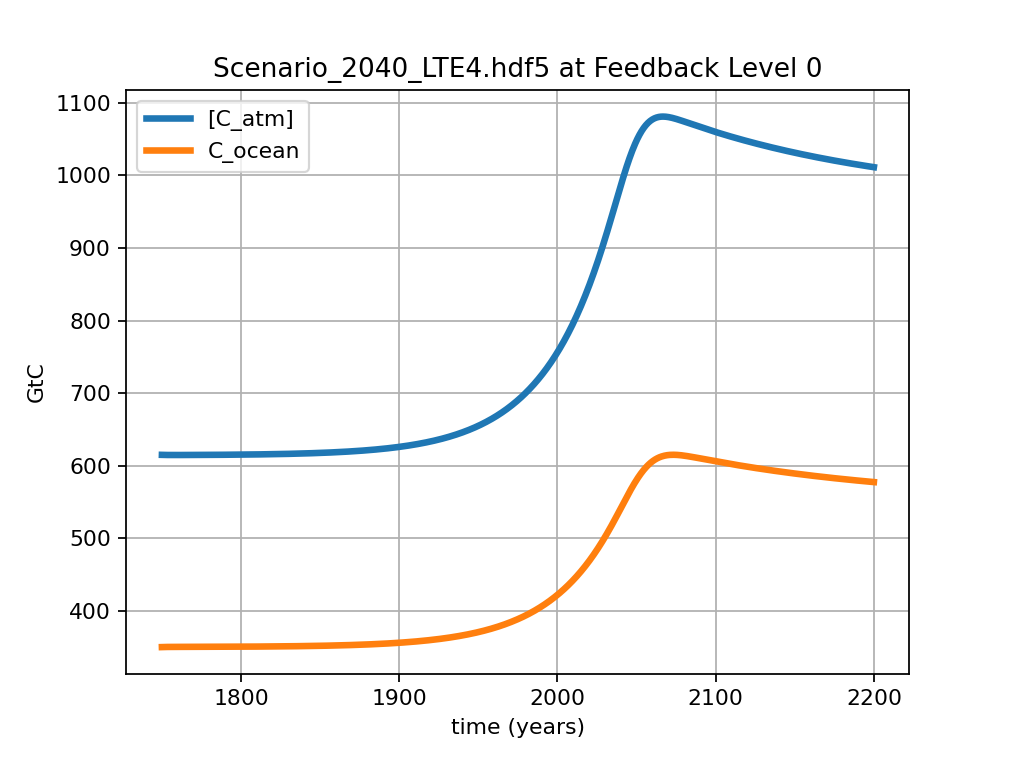

<IPython.core.display.Javascript object>


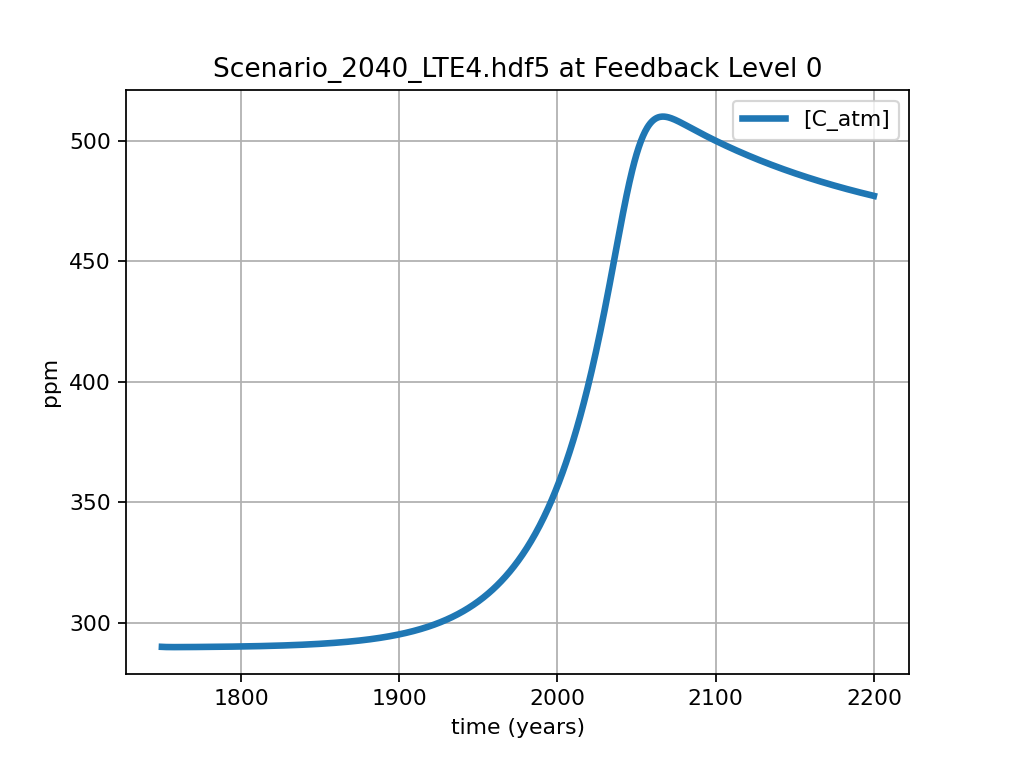

Text(0.5, 1.0, 'Scenario_2040_LTE4.hdf5 at Feedback Level 0')

In [9]:
# Extract and plot the concentration of carbon in the atmosphere and oceans, in GtC (one graph)
### BEGIN SOLUTION
C_atm_array = CL.CollectClimateTimeSeries(ClimateState_list,'C_atm')
C_ocean_array = CL.CollectClimateTimeSeries(ClimateState_list,'C_ocean')
plt.figure()
plt.plot(time,C_atm_array,label='[C_atm]',linewidth=lnw)
plt.plot(time,C_ocean_array,label='C_ocean',linewidth=lnw)
plt.grid(True)
plt.xlabel('time (years)')
plt.ylabel("GtC")
plt.legend()
plt.title(plot_title)
### END SOLUTION

# Re-plot the carbon in the atmosphere, converted to ppm (by dividing C_atm_array by 2.12)
### BEGIN SOLUTION
plt.figure()
plt.plot(time,C_atm_array/2.12,label='[C_atm]',linewidth=lnw)
plt.grid(True)
plt.xlabel('time (years)')
plt.ylabel("ppm")
plt.legend()
plt.title(plot_title)
### END SOLUTION

<IPython.core.display.Javascript object>


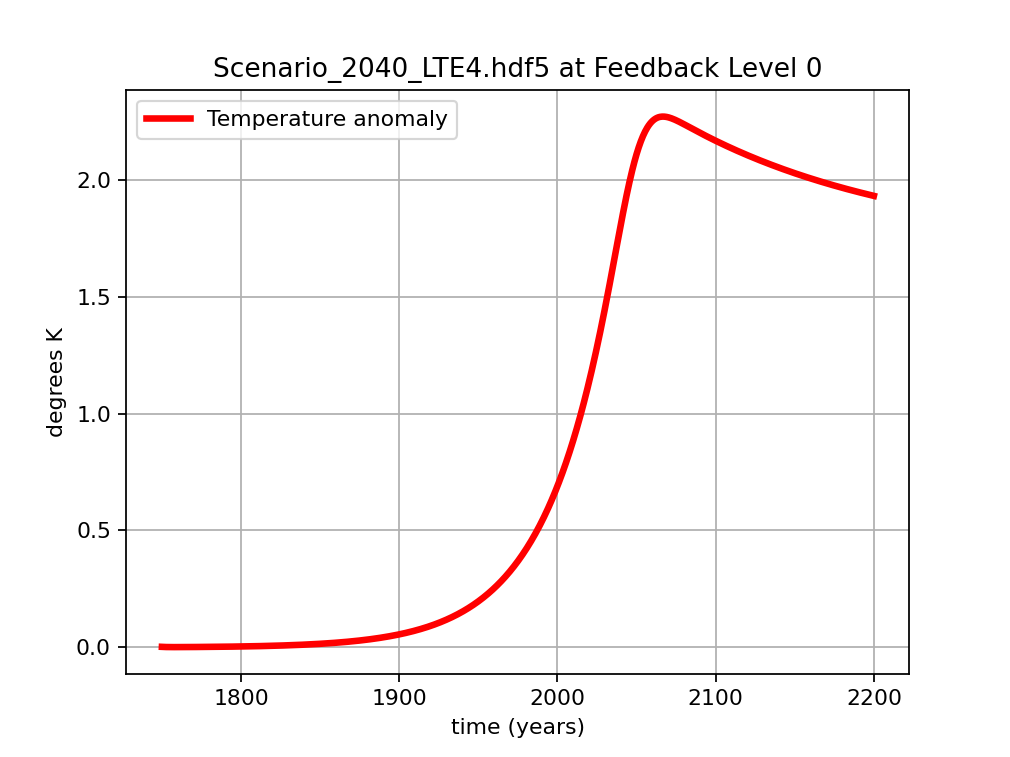

Text(0.5, 1.0, 'Scenario_2040_LTE4.hdf5 at Feedback Level 0')

In [10]:
# Extract and plot the temperature anomaly
### BEGIN SOLUTION
T_array = CL.CollectClimateTimeSeries(ClimateState_list,'T_anomaly')
plt.figure()
plt.plot(time,T_array,label='Temperature anomaly',linewidth=lnw,color='red')
plt.grid(True)
plt.xlabel('time (years)')
plt.ylabel("degrees K")
plt.legend()
plt.title(plot_title)
### END SOLUTION

<IPython.core.display.Javascript object>


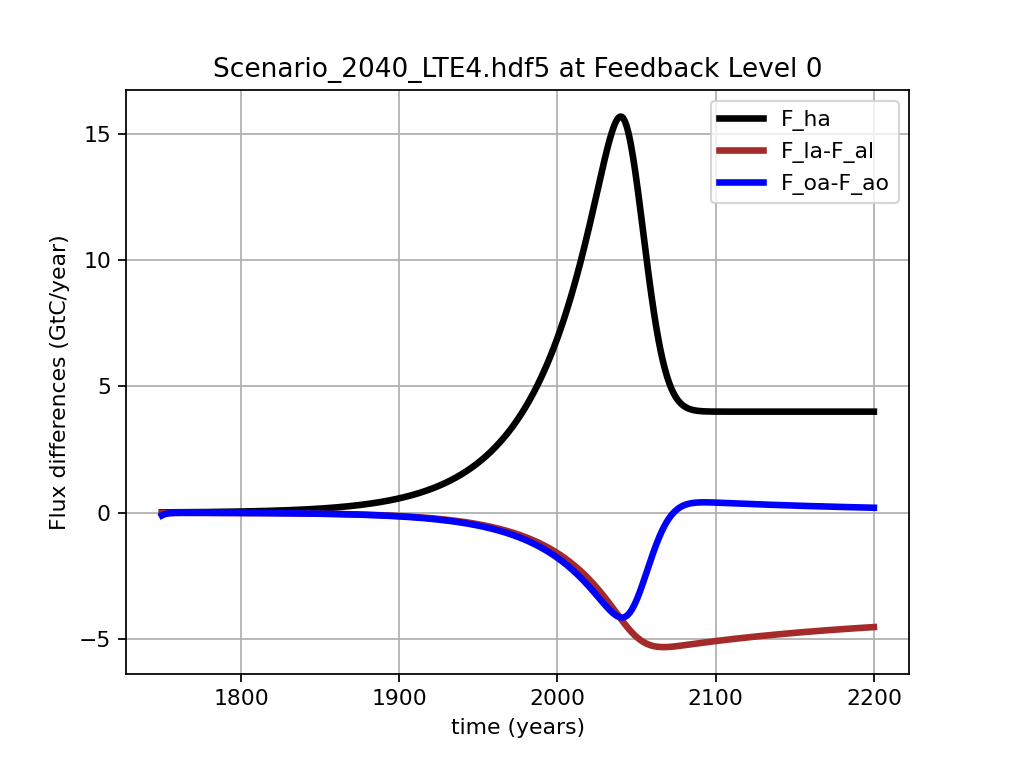

Text(0.5, 1.0, 'Scenario_2040_LTE4.hdf5 at Feedback Level 0')

In [11]:
# Extract the fluxes, compute net fluxes, and plot them
### BEGIN SOLUTION
F_al_array = CL.CollectClimateTimeSeries(ClimateState_list,'F_al')
F_la_array = CL.CollectClimateTimeSeries(ClimateState_list,'F_la')
F_ao_array = CL.CollectClimateTimeSeries(ClimateState_list,'F_ao')
F_oa_array = CL.CollectClimateTimeSeries(ClimateState_list,'F_oa')
F_ha_array = CL.CollectClimateTimeSeries(ClimateState_list,'F_ha')

plt.figure()
# fontsize=12
# plt.rcParams.update({'font.size': fontsize})
plt.plot(time,F_ha_array,label='F_ha',color='black',linewidth=lnw)
plt.plot(time,-F_al_array+F_la_array,label='F_la-F_al',color='brown',linewidth=lnw)
plt.plot(time,-F_ao_array+F_oa_array,label='F_oa-F_ao',color='blue',linewidth=lnw)
plt.grid(True)
plt.xlabel('time (years)')
plt.ylabel("Flux differences (GtC/year)")
plt.legend()
plt.title(plot_title)
### END SOLUTION

<IPython.core.display.Javascript object>


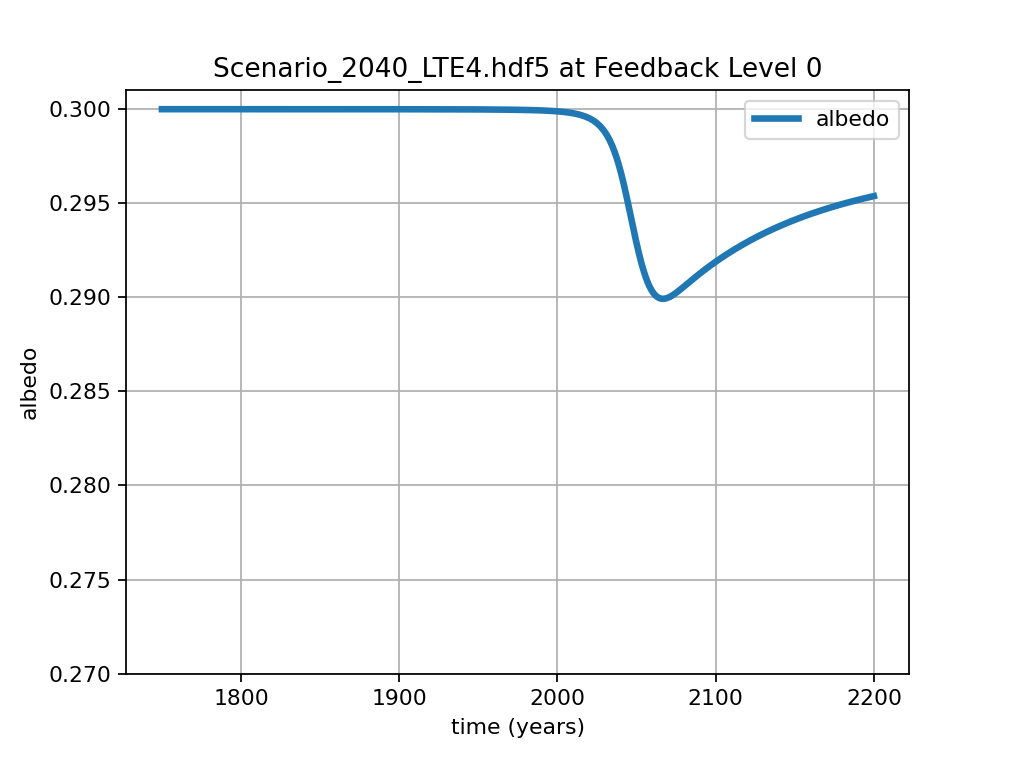

(0.27, 0.301)

In [12]:
# Extract and plot the albedo, specifying vertical limits 0.27 to 0.301 (or whatever looks best)
### BEGIN SOLUTION
albedo_array = CL.CollectClimateTimeSeries(ClimateState_list,'albedo')
plt.figure()
plt.plot(time,albedo_array,label='albedo',linewidth=lnw)
plt.grid(True)
plt.xlabel('time (years)')
plt.ylabel("albedo")
plt.legend()
plt.title(plot_title)
plt.ylim(0.27,0.301)
### END SOLUTION

<IPython.core.display.Javascript object>


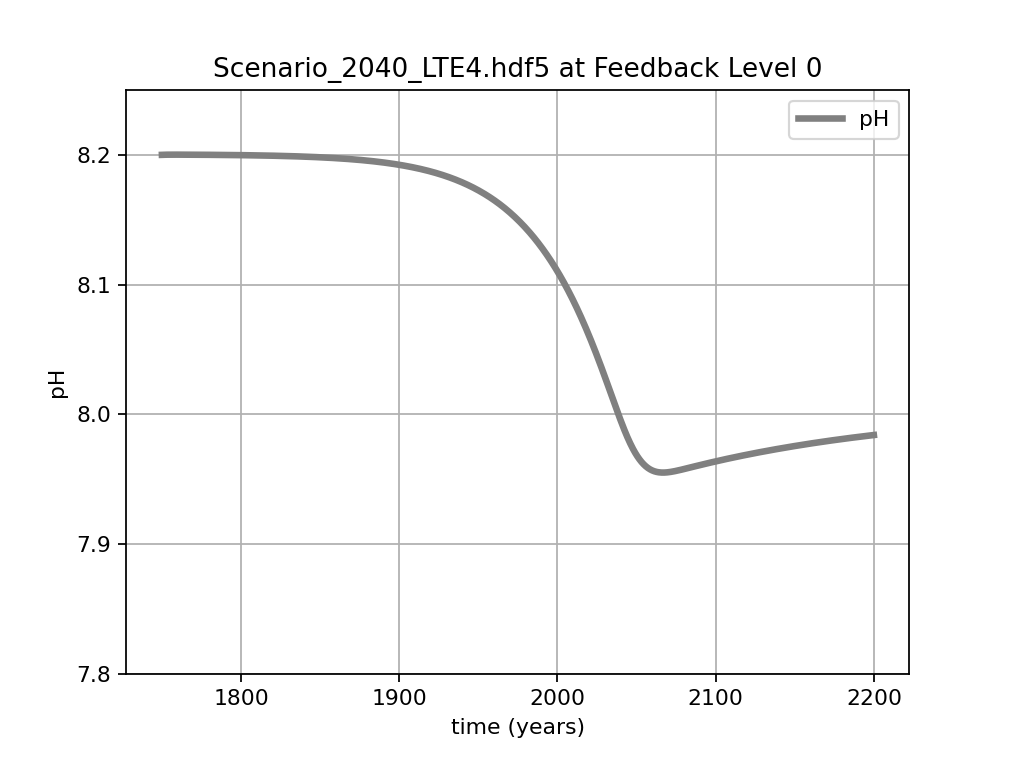

Text(0.5, 1.0, 'Scenario_2040_LTE4.hdf5 at Feedback Level 0')

In [13]:
# Extract and plot the ocean pH, specifying vertical axis limits of 7.8 to 8.25 (or whatever looks best)
### BEGIN SOLUTION
pH_array = CL.CollectClimateTimeSeries(ClimateState_list,'pH')
plt.figure()
plt.plot(time,pH_array,label='pH',linewidth=lnw,color='gray')
plt.grid(True)
plt.xlabel('time (years)')
plt.ylabel("pH")
plt.legend()
plt.ylim([7.8, 8.25])
plt.title(plot_title)
### END SOLUTION

### Pause for analysis
Below is shown benchmark aganist which you can compare your Level 3 feedback algorithm.

<p style='text-align: center;'>
<img src="http://webspace.pugetsound.edu/facultypages/nesh/Notebook/Level 3 temperature.png" height="500" width="500"/> Sample temperature for Level 3 feedbacks.
</p>

Once you're satisfied with your feedback algorithms, your task will be to create an emissions scenario (using ScheduledFlowsLTE) whose temperature gets as close to 2.5 degrees C as possible, without ever rising above that temperature, even for Level 3 feedbacks.

### Refresh/save/validate
Double-check everything is OK, and press the "Validate" button (as usual).

### Close/submit/logout
Close, submit, and log out.